# Computer Vision Final Project

### Team Members: Cuong Pham, Yosep Kim, Chelle Cruz, David Yardimian

----------------------------------------------------------------------------------------------------------------------

### 1.0 Dependencies

* Install `OpenCV` for Anaconda with the following command:  `conda install -c conda-forge opencv`
* Install  `imutils` with the following command:  `sudo pip install imutils`

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from random import shuffle
from random import randint
import imutils #need to install this with pip
import matplotlib.pyplot as plt
from skimage import data, color, exposure
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# displays graphs and images in cells instead of in a new window
# %matplotlib inline
# %pylab inline 

### 2.0 Dependencies 

* The following functions help simplify some of the routines and have been collected into one cell
* Make sure to run this cell again if you change anything
* Non-max-suppression was found at https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/


In [2]:
### helper functions

def load_positives(count):
    pimages = []
    for i in range(1, count+1):
        path = "imgs/coffee_imgs/" + "{}".format(i).rjust(4, '0') + ".jpg"
        img = cv2.imread(path, 1)
        if img is not None:
            pimages.append(resize(img))
    return pimages

def load_negatives(count):
    nimages = []
    for i in range(1, count+1):
        path = "imgs/random_imgs/" + "{}".format(i).rjust(4, '0') + ".jpg"
        img = cv2.imread(path)
        if img is not None:
            nimages.append(resize(img))
    return nimages

#GET HOG features
def get_features_w_label(imageData, hog, dims, label):
    data = []
    for img in imageData: 
        img = cv2.resize(img, dims)

        #for images with transparency layer, reduce to 3 layers
        feat = hog.compute(img[:,:,:3])
        
        data.append((feat, label))
    return data

def resize(img):
    if img.shape[0] != 128:
        scale = 128.0/img.shape[0]
    else: scale = 1
    return cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))

def preprocess(image, lower, upper):
    #boundary in bgr color scheme for opencv

    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")

    # find the colors within the specified boundaries and apply
    # the mask
    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask = mask)
    #This takes image[x] and image[x] when mask is 1 (that is, it leaves it alone),
    #otherwise it makes image[x] = 0.9 The effect in this case is just image and mask. 
    #This is applied to all 3 channels
    
    return output, mask

def transform_scale(factor, boxes):
    return [[int(x[0]*factor), int(x[1]*factor), int(x[2]*factor), int(x[3]*factor)] for x in boxes]

# non_max_suppresssion function to reduce overlapping bounding boxes
# taken from https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/
# Felzenszwalb et al.
def non_max_suppression(boxes, overlapThresh):
    # if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
 
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
 
	# initialize the list of picked indexes	
	pick = []
 
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
 
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
 
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
 
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
 
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
 
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

### 3.0 Data Loading and Processing/Training

* This could take quite long so please be patient!
* Specify the number of positive and negative images you would like to load
* The loading functions will still take care of corrupted/null images so if you get less than the actual number you put in, that's why

In [3]:
# load positive images
pimages = load_positives(178)
print(len(pimages), "positive images")

# load negative images
nimages = load_negatives(112)
print(len(nimages), "negative images")

178 positive images
112 negative images


### Positive Images

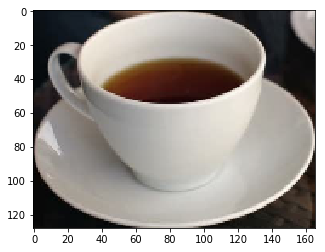

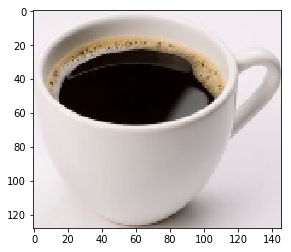

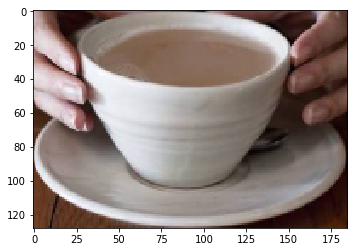

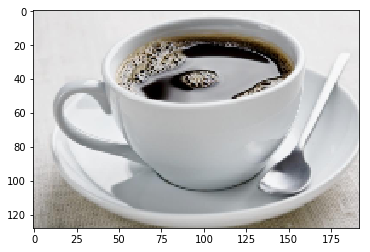

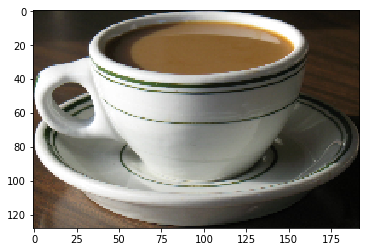

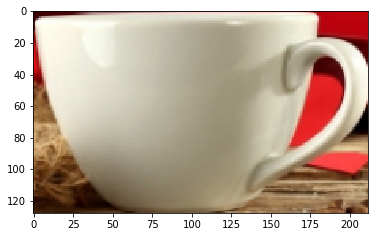

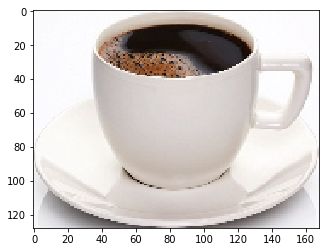

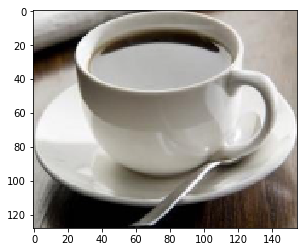

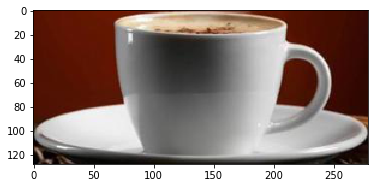

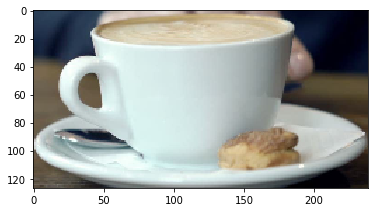

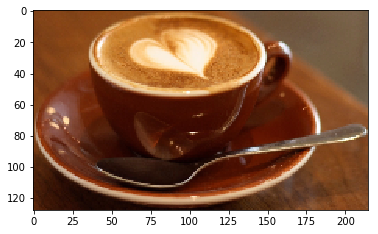

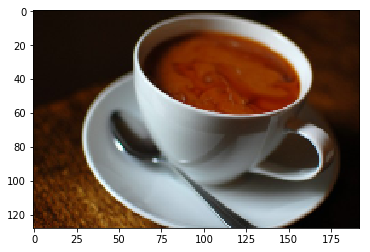

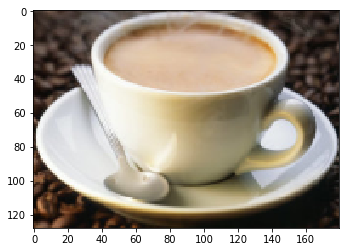

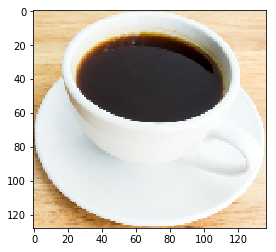

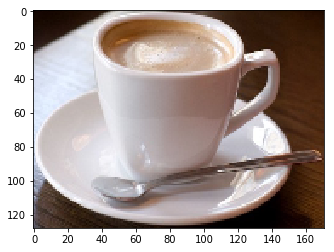

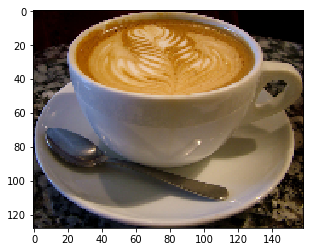

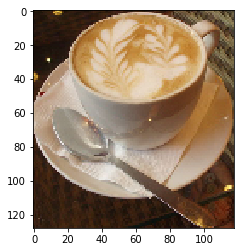

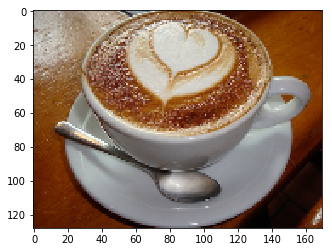

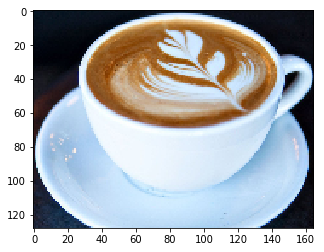

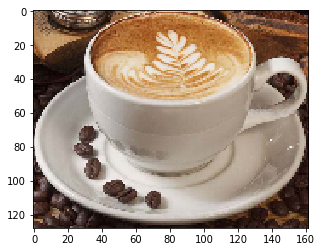

In [4]:
for image in pimages[0:20]:
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

### Negative Images

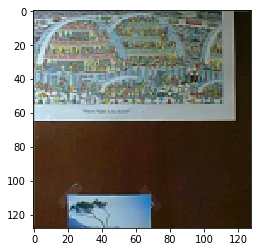

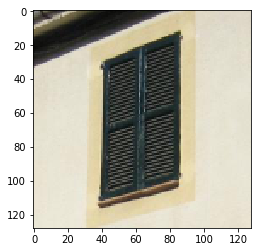

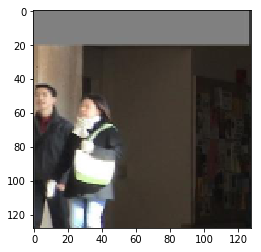

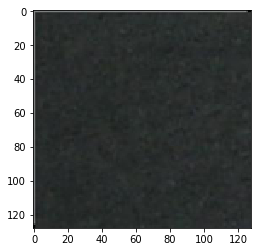

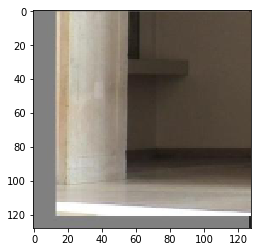

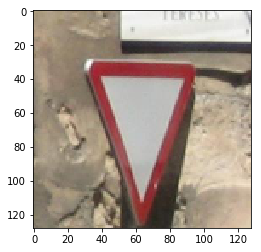

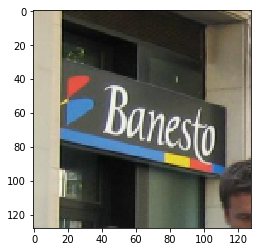

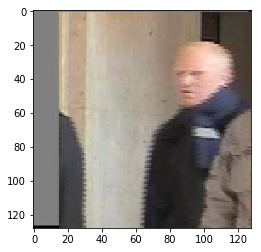

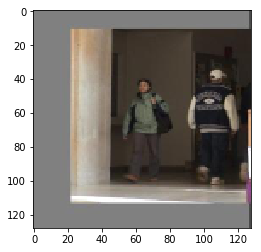

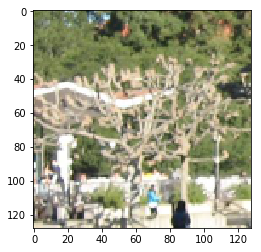

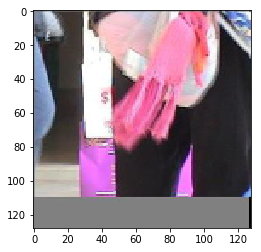

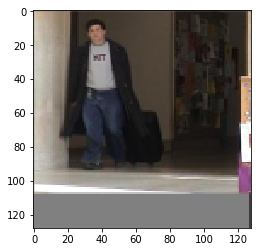

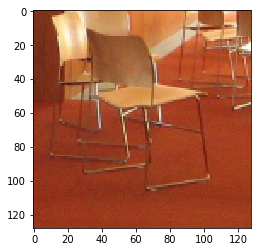

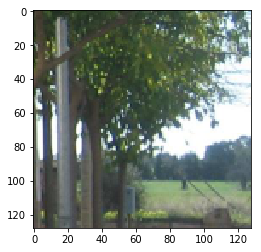

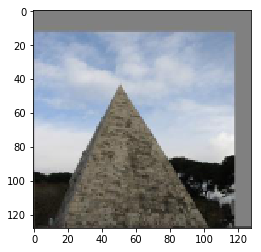

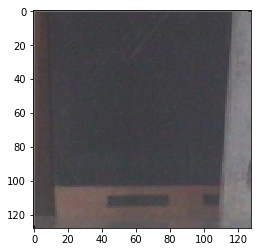

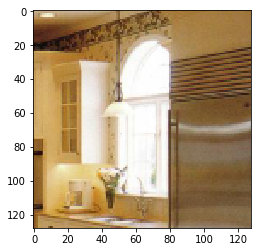

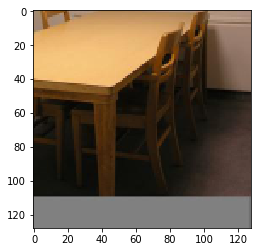

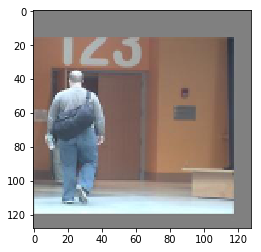

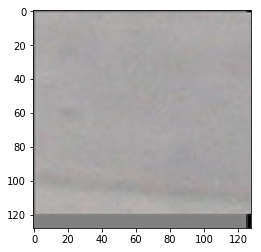

In [5]:
for image in nimages[0:20]:
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

### Create HOG

In [6]:
minDim = 256
blockSize = (32,32)
blockStride = (16,16)
cellSize = (16,16)
nbins = 8

dims = (minDim, minDim)

hog = cv2.HOGDescriptor(dims, blockSize, blockStride, cellSize, nbins)

Below I just get hog features for all the images, concatenate pos and negs into an array, shuffle, then create train and test features and labels.

In [7]:
pdata = get_features_w_label(pimages, hog, dims, 1)
ndata = get_features_w_label(nimages, hog, dims, 0)

data = pdata + ndata
shuffle(data)

# Extract feat and labels from each data tuple
#Flatten the feat arrays
feat, labels = map(list, zip(*data))
feat = [x.flatten() for x in feat]

#Split X and y into testing and training sets
sample_size = len(feat)
train_size = int(round(0.8*sample_size))

train_feat = np.array(feat[:train_size], np.float32)
test_feat = np.array(feat[train_size: sample_size], np.float32)
train_label = np.array(labels[:train_size])
test_label = np.array(labels[train_size:sample_size])

### Create SVM

In [8]:
lsvm = svm.SVC(kernel='linear', C = 1.0, probability=True)
lsvm.fit(train_feat, train_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [9]:
print("Training score:", lsvm.score(train_feat, train_label))

Training score: 1.0


In [10]:
# compute test accuracy
print("Test accuracy:", lsvm.score(test_feat, test_label))
y_pred = lsvm.predict(test_feat)
print(classification_report(test_label, y_pred))

# confusion matrix
confusion_matrix(y_pred, test_label)

Test accuracy: 0.98275862069
             precision    recall  f1-score   support

          0       0.96      1.00      0.98        26
          1       1.00      0.97      0.98        32

avg / total       0.98      0.98      0.98        58



array([[26,  1],
       [ 0, 31]])

In [11]:
results = pd.DataFrame({'Prediction': y_pred, 'Actual': test_label})
results

,Actual,Prediction
0,1,1
1,1,1
2,1,1
3,1,1
4,0,0
5,0,0
6,1,1
7,0,0
8,1,1
9,1,1


### 4.0 Image Recognition Test

* Change test_img to the path of the test image you would like to try
* Recognition is done using Canny to find the edges and then contours are found using the built-in find_contours() function
* Non-max-suppression is used to simplify displaying bounding boxes
* A simple match/miss test is done on the final bounding boxes to see if the majority of the bounding boxes in the image were a match with the training data set

### Test Image

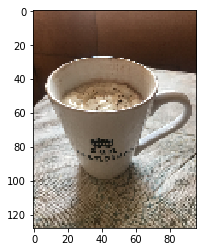

In [12]:
test_img = "imgs/coffee-test3.jpg"

# load the test image in color and grayscale
img = cv2.imread(test_img, 1)

#Resize image
img = cv2.resize(img, (0,0), fx=0.25, fy=0.25) #resize both axis by quarter
img = resize(img)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
def auto_canny(img, sigma=0.33):
    v = np.median(img)
    
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(img, lower, upper)
    
    return edged
    

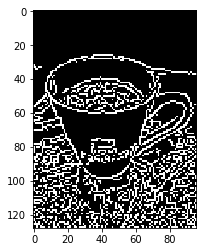

In [14]:
# binaryImage = cv2.Canny(img, 100, 200)
binaryImage = auto_canny(img)
plt.imshow(binaryImage, cmap='gray')
plt.show()

### Get contours

In [15]:
im2, contours, hierarchy = cv2.findContours(binaryImage,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

196
3
3


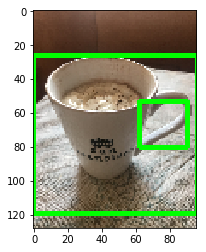

In [16]:
copy = img.copy()
#copy = cv2.bitwise_not(im)
rgb = cv2.cvtColor(copy, cv2.COLOR_BGR2RGB)

boxes = [cv2.boundingRect(c) for c in contours]
print(len(boxes))
#boxes2 = [b for b in boxes if b[2]*b[3] > 150 and b[2]*b[3]<5000]
boxes2 = [b for b in boxes if b[2]*b[3] > 600]
print(len(boxes2))

boxes3 = non_max_suppression(np.array(boxes2), 0.3)
#bboxes = boxes2.copy()
print(len(boxes3))

for x, y, w, h in boxes3:
    #if x < rgb.shape[1]*4/5 and y > rgb.shape[0]/3 and y < rgb.shape[0]*3/4:
    cv2.rectangle(rgb, (x,y),(x+w, y+h), (0, 255, 0), 2)
plt.imshow(rgb)
plt.show()

In [17]:
real_feats = []

for x, y, w, h in boxes2:
    #get slice at box:
    window = img[y:y+h, x:x+w, :3]
    window = cv2.resize(window, dims)
    feat = hog.compute(window)
    prob = lsvm.predict_proba(feat.reshape(1,-1))[0]          
#     plt.imshow(cv2.cvtColor(window, cv2.COLOR_BGR2RGB))
#     plt.show()
#     print prob[1]
    if prob[1] > .1:  
        real_feats.append((x,y,w,h))
    
print(len(real_feats))

1


1


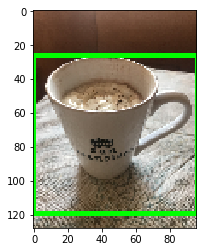

True

In [18]:
clone = img.copy()

colors = [(0,255,0),(0,0,0),(255,0,255),(255,0,0),(255,165,0),(255,255,255), (1, 1, 1)]

real_feats = non_max_suppression(np.array(real_feats), 0.3)
print(len(real_feats))

for x, y, w, h in real_feats:
    cv2.rectangle(clone, (x, y), (x+w, y+h), colors[0], 2)

plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.show()

cv2.imwrite('test-result.jpg', clone)

In [19]:
l_orig = len(boxes3)
l_feat = len(real_feats)
l_diff = abs(l_orig - l_feat)
l_max = max(l_orig, l_feat)

# if the number of final bounding boxes ~80%
# then we can consider it a match!
if l_diff / l_max <= 0.2:
    print("It's a match!")
else:
    print("It's a miss!")

It's a miss!


### Incorporate web cam

In [20]:
# def show_webcam(mirror=False):
#     cam = cv2.VideoCapture(0)
#     while True:
#         ret_val, img = cam.read()
#         if mirror: 
#             img = cv2.flip(img, 1)
#         cv2.imshow('my webcam', img)
#         if cv2.waitKey(1) == 27: 
#             break  # esc to quit

#     cv2.destroyAllWindows()

def detect_coffee(img):
    #Coffee cup detection
        img = cv2.resize(img, (0,0), fx=0.25, fy=0.25) #resize both axis by quarter
        img = resize(img)
        binaryImage = cv2.Canny(img, 100, 200)
        im2, contours, hierarchy = cv2.findContours(binaryImage,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        copy = img.copy()
        #copy = cv2.bitwise_not(im)
        rgb = cv2.cvtColor(copy, cv2.COLOR_BGR2RGB)

        boxes = [cv2.boundingRect(c) for c in contours]
#         print(len(boxes))
        #boxes2 = [b for b in boxes if b[2]*b[3] > 150 and b[2]*b[3]<5000]
        boxes2 = [b for b in boxes if b[2]*b[3] > 1200]
#         print(len(boxes2))

        boxes3 = non_max_suppression(np.array(boxes2), 0.3)
        #bboxes = boxes2.copy()
#         print(len(boxes3))

        for x, y, w, h in boxes3:
            #if x < rgb.shape[1]*4/5 and y > rgb.shape[0]/3 and y < rgb.shape[0]*3/4:
            cv2.rectangle(rgb, (x,y),(x+w, y+h), (0, 255, 0), 2)
        
        real_feats = []

        for x, y, w, h in boxes2:
            #get slice at box:
            window = img[y:y+h, x:x+w, :3]
            window = cv2.resize(window, dims)
            feat = hog.compute(window)
            prob = lsvm.predict_proba(feat.reshape(1,-1))[0]          
        #     plt.imshow(cv2.cvtColor(window, cv2.COLOR_BGR2RGB))
        #     plt.show()
        #     print prob[1]
            if prob[1] > .1:  
                real_feats.append((x,y,w,h))

#         print(len(real_feats))
        
        clone = img.copy()

        colors = [(0,255,0),(0,0,0),(255,0,255),(255,0,0),(255,165,0),(255,255,255), (1, 1, 1)]

        real_feats = non_max_suppression(np.array(real_feats), 0.3)
#         print(len(real_feats))

        for x, y, w, h in real_feats:
            cv2.rectangle(clone, (x, y), (x+w, y+h), colors[0], 2)
         
        cv2.imshow('my webcam', clone)
    

def show_webcam(mirror=False):
    cam = cv2.VideoCapture(0)
    while True:
        ret_val, img = cam.read()
        if mirror: 
            img = cv2.flip(img, 1)
        
        detect_coffee(img)
        
        if cv2.waitKey(1) == 27: 
            break  # esc to quit
    cam.release()
    cv2.destroyAllWindows()

In [21]:
# show_webcam(mirror=True)